<a href="https://colab.research.google.com/github/max1nehour/Python_projects/blob/main/LSTM_low%20perf_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import matplotlib.dates as mdates
import pandas as pd
from glob import glob

#列出檔名開頭pm25的檔案
dataset_train = glob('drive/MyDrive/1718data/pm25*.csv')
print(dataset_train)

dataset_test = glob('drive/MyDrive/20data/pm25*.csv')
print(dataset_test)

#以列合併train data 僅讀取'Date','area','PM2_5_avg' 設定欄位資料型態'Date': str, 'area':str
df_train = pd.concat(
    (pd.read_csv(file, usecols=['Date','area','PM2_5_avg'], dtype={ 'Date': str, 'area':str}) for file in dataset_train ), ignore_index=True)
print(df_train)

df_test = pd.concat(
    (pd.read_csv(file, usecols=['_monitordate_','area','avg'], dtype={ 'Date': str, 'area':str}) for file in dataset_test ), ignore_index=True)
print(df_test)




['drive/MyDrive/1718data/pm25嘉義第二包.csv', 'drive/MyDrive/1718data/pm25小港第二包.csv', 'drive/MyDrive/1718data/pm25忠明第二包.csv', 'drive/MyDrive/1718data/pm25斗六第二包.csv', 'drive/MyDrive/1718data/pm25板橋第二包.csv', 'drive/MyDrive/1718data/pm25花蓮第二包.csv']
['drive/MyDrive/20data/pm25嘉義2020.csv', 'drive/MyDrive/20data/pm25小港2020.csv', 'drive/MyDrive/20data/pm25忠明2020.csv', 'drive/MyDrive/20data/pm25斗六2020.csv', 'drive/MyDrive/20data/pm25板橋2020.csv', 'drive/MyDrive/20data/pm25花蓮2020.csv']
           Date     area  PM2_5_avg
0    2017-01-31   Chiayi  38.983884
1    2017-02-24   Chiayi  40.523379
2    2017-03-26   Chiayi  42.621849
3    2017-04-25   Chiayi  46.797105
4    2017-05-31   Chiayi  24.429865
..          ...      ...        ...
211  2019-08-31  Hualien   7.620267
212  2019-09-24  Hualien   8.299339
213  2019-10-24  Hualien  15.643017
214  2019-11-29  Hualien  10.236687
215  2019-12-23  Hualien   6.559387

[216 rows x 3 columns]
   _monitordate_        avg     area
0      1/31/2020  28.580645   C

In [35]:
# Import the training set 2019以前
site = 'Douliu'
filt = (df_train['area'] == site)
training_set = df_train.loc[filt, ['PM2_5_avg']].values
print(training_set)
training_set.shape

[[38.93268746]
 [41.10496842]
 [41.43705937]
 [52.70961202]
 [26.65895324]
 [13.79443603]
 [17.50144786]
 [17.55620005]
 [22.98663599]
 [27.9194849 ]
 [24.82110353]
 [27.87549235]
 [30.84871166]
 [35.75052982]
 [38.87992852]
 [35.30434441]
 [19.80849588]
 [18.79425248]
 [15.48573492]
 [16.72114403]
 [23.41120253]
 [22.81471247]
 [30.10144048]
 [26.28543088]
 [28.79771322]
 [39.0322794 ]
 [30.92411733]
 [27.48975339]
 [25.29414515]
 [11.58600672]
 [14.7276844 ]
 [19.56275777]
 [23.73231859]
 [35.55328448]
 [27.71978279]
 [31.77784991]]


(36, 1)

做 Normalization，將資料壓縮在 [0,1] 之間

In [36]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1)) #控制最大值最小值範圍
training_set_scaled = sc.fit_transform(training_set)#fit_transform: 先對partData作fit()的功能，找到該partData的整體統計特性之指標，如平均值、標準差、最大最小值等等(能依據不同目的套用這些指標在不同的轉換(即後面的transform()動作)上，再實行transform(partData)以對partData進行標準化
print(training_set_scaled.shape)
#training_set_scaled = training_set

(36, 1)


準備進入訓練的資料格式：設定 Timestep 設為 60 ，代表過去 60 天的資訊，嘗試過數值設置太少，將使 RNN 無法學習。

In [37]:
X_train = []
y_train = []
for i in range(1, 36):  # 訓練集總數36
    X_train.append(training_set_scaled[i-1:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN

Reshape
因為現在 X_train 是 2-dimension，將它 reshape 成 3-dimension: [stock prices, timesteps, indicators]

In [38]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#搭建一個 LSTM

In [39]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

搭建 LSTM layer

units: 神經元的數目

第一層的 LSTM Layer 記得要設定input_shape參數

搭配使用dropout，這裡設為 0.2

由於這邊的第四層 LSTM Layer 即將跟 Ouput Layer 做連接，因此注意這邊的 return_sequences 設為預設值 False （也就是不用寫上 return_sequences）

In [40]:
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [41]:
# Adding the output layer
regressor.add(Dense(units = 1))

#Compiling & Fitting LSTM model

optimizer: 選擇 Adam

loss: 使用 MSE

In [46]:
# Compiling
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
print(X_train.shape)
# 進行訓練
regressor.fit(X_train, y_train, epochs = 500, batch_size = 64)

(35, 1, 1)
Epoch 1/500
1/1 [==============================] - 11s 11s/step - loss: 0.0329
Epoch 2/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0281
Epoch 3/500
1/1 [==============================] - 0s 24ms/step - loss: 0.0291
Epoch 4/500
1/1 [==============================] - 0s 21ms/step - loss: 0.0257
Epoch 5/500
1/1 [==============================] - 0s 25ms/step - loss: 0.0262
Epoch 6/500
1/1 [==============================] - 0s 20ms/step - loss: 0.0279
Epoch 7/500
1/1 [==============================] - 0s 21ms/step - loss: 0.0320
Epoch 8/500
1/1 [==============================] - 0s 21ms/step - loss: 0.0243
Epoch 9/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0215
Epoch 10/500
1/1 [==============================] - 0s 20ms/step - loss: 0.0282
Epoch 11/500
1/1 [==============================] - 0s 20ms/step - loss: 0.0283
Epoch 12/500
1/1 [==============================] - 0s 20ms/step - loss: 0.0289
Epoch 13/500
1/1 [====================

# 進行預測

In [47]:
#取測試 2020的pm2.5
filt2 = (df_test['area'] == site)
real_pm25 = df_test.loc[filt2, ['avg']].values
print(real_pm25.shape) #61
print(real_pm25)
#real_pm25 = dataset_test.loc[filt2, ['pm25']]
#real_pm25

(12, 1)
[[29.32258065]
 [30.        ]
 [28.29032258]
 [25.83333333]
 [12.90322581]
 [22.48387097]
 [20.66666667]
 [ 8.33076923]
 [ 6.73529412]
 [ 6.2       ]
 [25.5       ]
 [21.90322581]]


In [48]:
#取模型所預測的 2017 年股票資料（預測
dataset_total = pd.concat((df_train['PM2_5_avg'], df_test['avg']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(df_test) - 1:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # Feature Scaling

X_test = []
for i in range(1,13): # timesteps一樣60； 81 = 20+61
    X_test.append(inputs[i- 1:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

In [49]:
#進行預測
predicted_pm25 = regressor.predict(X_test)
predicted_pm25 = sc.inverse_transform(predicted_pm25)  # to get the original scale

1/1 [==============================] - 2s 2s/step


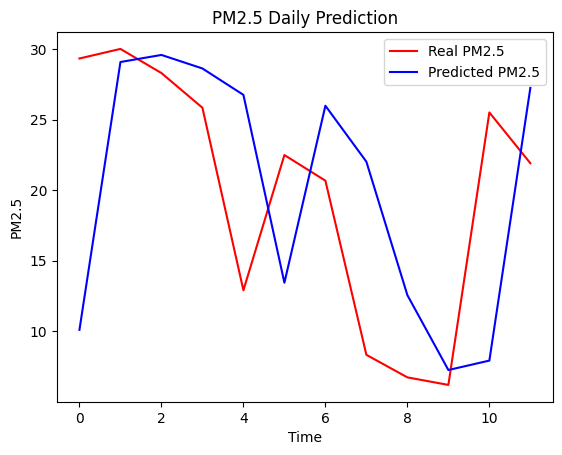

In [50]:
#x = df_test['Date']
plt.plot(real_pm25, color = 'red', label = 'Real PM2.5')  # 紅線表示真實股價
plt.plot(predicted_pm25, color = 'blue', label = 'Predicted PM2.5')  # 藍線表示預測股價
plt.title('PM2.5 Daily Prediction')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()


In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(real_pm25.shape)
print(predicted_pm25.shape)
rmse = np.sqrt(mean_squared_error(real_pm25, predicted_pm25))
mae = mean_absolute_error(real_pm25, predicted_pm25)

print("RMSE:", rmse)
print("MAE:", mae)

(12, 1)
(12, 1)
RMSE: 10.16871291073903
MAE: 7.990143662138654


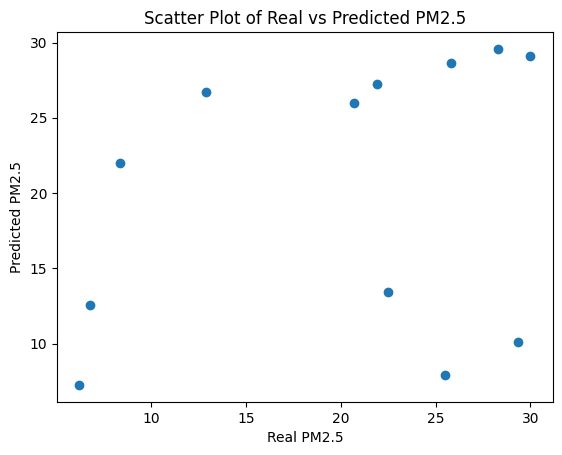

In [53]:
plt.scatter(real_pm25, predicted_pm25)
plt.xlabel('Real PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Scatter Plot of Real vs Predicted PM2.5')
plt.show()